In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.__version__

'1.23.4'

In [3]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f


from dotenv import load_dotenv
load_dotenv()

True

In [4]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

# Data Paths
data_root = "../../../"
data_path = data_root + "data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = data_root + "data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = data_root + "data/nw2/simulations/" + location + "/"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [5]:
weather_inputs = make_dataset.get_weather_subset(mvbc_data)
scada_inputs = make_dataset.get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [6]:
from interpret.glassbox import ExplainableBoostingRegressor

mode = 'SS1'
random_state = 42
test_size = 0.2

y = prediction_params[mode].dropna()
X = inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=test_size, random_state=random_state)


ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, y_train)


ExplainableBoostingRegressor()

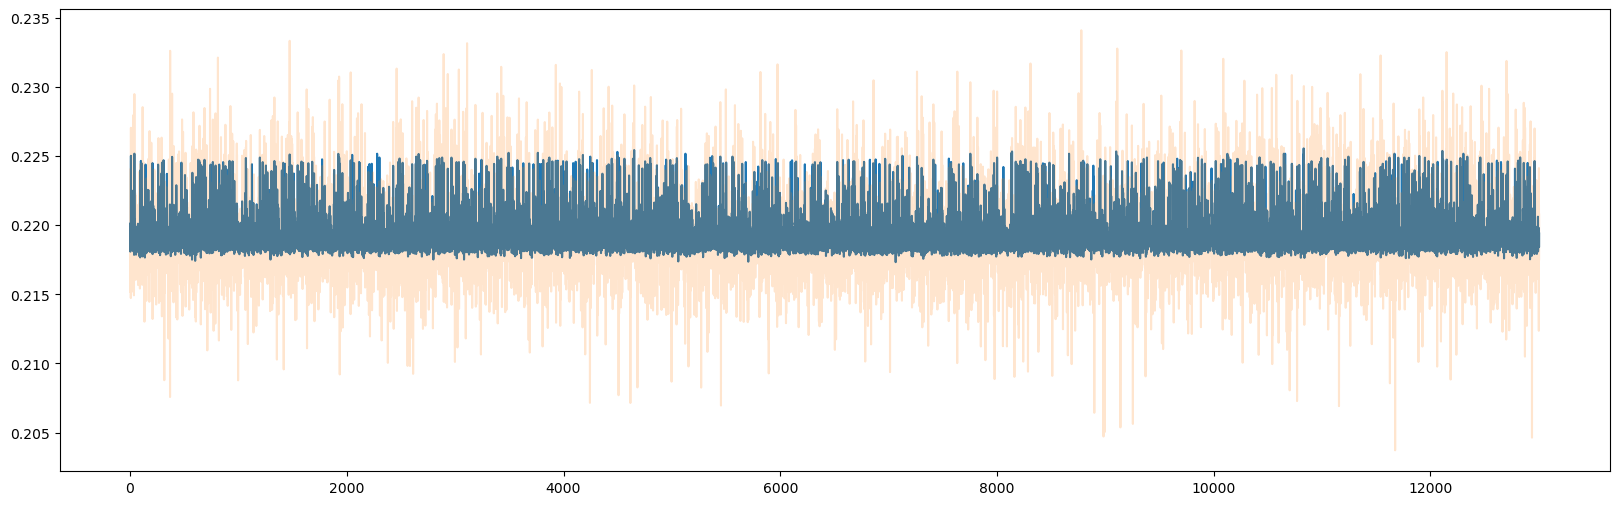

0.28118811741077454


In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.plot(ebm.predict(X_train))
plt.plot(y_train.values, alpha=0.2)
plt.show()
print(ebm.score(X_train, y_train))

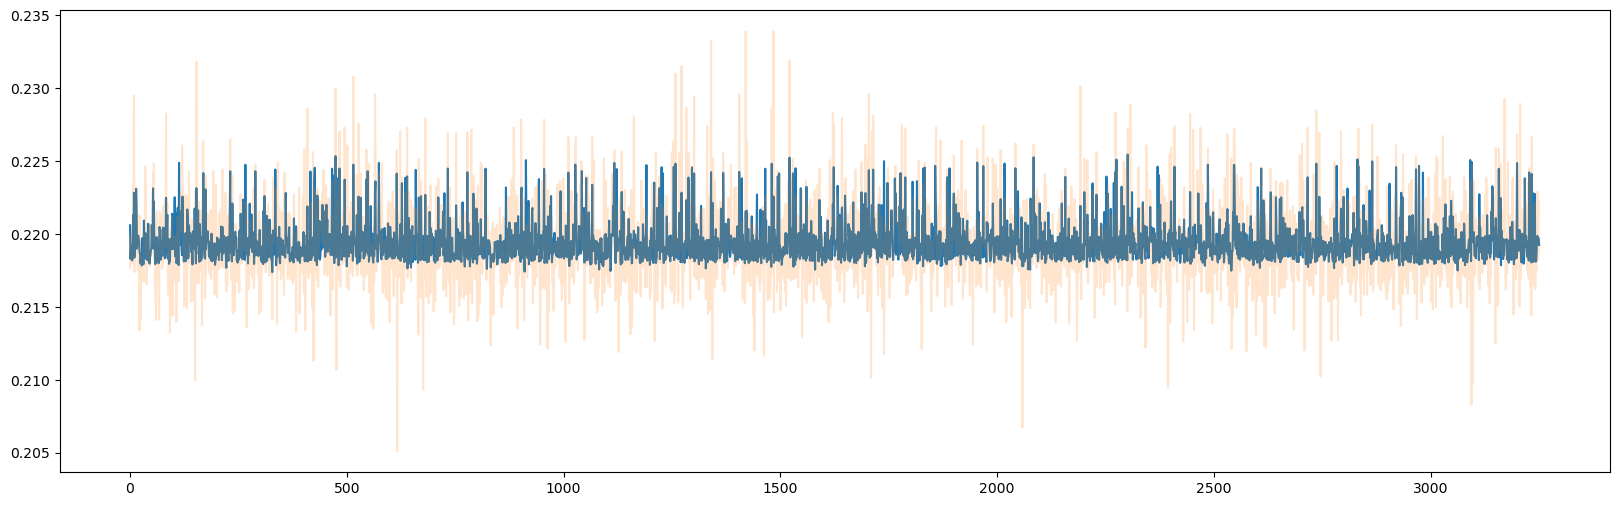

0.28221087538136513


In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.plot(ebm.predict(X_test))
plt.plot(y_test.values, alpha=0.2)
plt.show()
print(ebm.score(X_test, y_test))

In [9]:
from interpret import show

ebm_global = ebm.explain_global(X_test)
ebm_global.visualize()

In [12]:
show(ebm_global)

<!-- http://127.0.0.1:7001/2453845888496/ -->

In [18]:
from interpret.data import Marginal
marginal = Marginal().explain_data(X_train, y_train, name = 'Train Data')
show(marginal)

<!-- http://127.0.0.1:7001/2454077887440/ -->

In [15]:
from interpret import show
from interpret.perf import RegressionPerf

ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7001/2454137310224/ -->

In [13]:
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)

<!-- http://127.0.0.1:7001/2453511934736/ -->